In [1]:
import numpy
import scipy
import pandas
import spacy
import textacy

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [3]:
corpus = textacy.Corpus.load(path='/home/immersinn/gits/ncga/data/processed/CORPUS_bills_filed_pipe01/',
                           name='CORPUS_bills_filed_pipe01',
                           compression='gzip')

### Tokenize and Vectorize Corpus

In [4]:
terms_lists = (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True) for doc in corpus)
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(\
                                                       terms_lists, 
                                                       weighting='tfidf', normalize=True, smooth_idf=True,
                                                       min_df=3, max_df=0.95, max_n_terms=1000)
doc_term_matrix

<2098x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 247753 stored elements in Compressed Sparse Row format>

### Topic Model

In [7]:
n_topics = 4
model = textacy.tm.TopicModel('lda', n_topics=n_topics)
model.fit(doc_term_matrix)

#### Transform the corpus and Interpret the Model:

In [8]:
doc_topic_matrix = model.transform(doc_term_matrix)

In [9]:
doc_topic_matrix.shape

(2098, 4)

In [10]:
# Rows sum to unity...
doc_topic_matrix[:10,:]

array([[ 0.04006075,  0.88406709,  0.03798571,  0.03788646],
       [ 0.07234805,  0.78724429,  0.07004595,  0.07036171],
       [ 0.01829032,  0.94812449,  0.01683505,  0.01675014],
       [ 0.06037106,  0.83623807,  0.05153815,  0.05185272],
       [ 0.04981398,  0.81500027,  0.0878845 ,  0.04730126],
       [ 0.03141068,  0.91373558,  0.02723571,  0.02761803],
       [ 0.24806708,  0.66059208,  0.04549823,  0.04584261],
       [ 0.02670665,  0.92355787,  0.02480258,  0.0249329 ],
       [ 0.02614035,  0.88732876,  0.06103577,  0.02549512],
       [ 0.57191424,  0.36283075,  0.03251098,  0.03274404]])

#### View Top Terms, Top Keywords from Top Documents

In [11]:
pandas.Series(doc_topic_matrix.reshape((doc_topic_matrix.shape[0]*doc_topic_matrix.shape[1],))).describe(percentiles=[0.75, 0.80, 0.90, 0.95, 0.975, 0.99])

count    8392.000000
mean        0.250000
std         0.329383
min         0.015022
50%         0.047603
75%         0.450906
80%         0.670733
90%         0.870961
95%         0.892481
97.5%       0.909019
99%         0.920180
max         0.948124
dtype: float64

In [12]:
sum(doc_topic_matrix > 0.1)

array([ 748, 1706,  102,  250])

In [13]:
top_term_table = []
index = []
for topic_idx, top_terms in model.top_topic_terms(id2term, top_n = 15, topics=range(n_topics)):
    index.append('topic ' + str(topic_idx))
    top_term_table.append({i : tt for i,tt in enumerate(top_terms)})
top_term_table = pandas.DataFrame(data=top_term_table, index=index)

In [14]:
top_term_table.transpose()

,topic 0,topic 1,topic 2,topic 3
0,school,shall,plate,tax
1,fund,state,animal,taxpayer
2,student,person,foot,income
3,education,district,registration,taxable
4,program,board,town,sale
5,shall,member,veteran,credit
6,health,commission,south,property
7,year,law,special,levy
8,board,county,page,food
9,state,senate,describe,investment


## Density-based Method for Adaptive LDA Model Selection

In [16]:
model.model.components_.shape

(4, 1000)

In [17]:
model.model.components_[:,:4]

array([[  0.25977875,   0.25774284,   0.47202631,   4.83220664],
       [  5.0444299 ,  16.20158631,   6.13205057,  11.19989377],
       [  0.25151976,   0.26379353,   1.25476955,   0.26803282],
       [  0.25731468,   0.27131475,   0.74280387,   1.68892231]])

In [118]:
# Calculate correlations between Topics in a given Model via the Topic - Term Weighting Vectors
def calc_p_topic_given_word(model, doc_topic_matrix, n_topics):
    # 01: Convert model components to a distribution --> p(w|t)
    p_word_given_topic = model.model.components_.copy()
    p_word_given_topic = p_word_given_topic / p_word_given_topic.sum(axis=1).reshape((n_topics,1))

    # 02: Calculate estimate of p(t) from corpus
    p_topics = (doc_topic_matrix.sum(axis=0) / len(corpus)).reshape((n_topics, 1))
    p_topics = p_topics + (1- p_topics.sum()) / n_topics  # Comp round error correct
    
    # 03: p(t|w) = p(w|t) * p(t) / p(w)
    p_words = doc_term_matrix.sum(axis=0) / doc_term_matrix.sum()
    p_words = p_words + (1 - p_words.sum()) / doc_term_matrix.shape[1]  # Comp round error correct
    
    # 04: Calculate p(t|w)
    p_topic_given_word = p_word_given_topic * p_topics / p_words
    p_topic_given_word = p_topic_given_word + (1 - p_topic_given_word.sum(axis=0)) / n_topics  #Comp round error correct

    return(p_topic_given_word)


def topic_cosdists(model, doc_topic_matrix, n_topics):
    ptw = calc_p_topic_given_word(model, doc_topic_matrix, n_topics)
    cos_dists = scipy.spatial.distance.squareform(\
                                                  scipy.spatial.distance.pdist(ptw, 'cosine')
                                                 )
    return(cos_dists)


def average_topic_distances(topic_distances, n_topics):
    if topic_distances.shape[0] == n_topics:
        if topic_distances.shape[1] == n_topics:
            topic_distances = topic_distances[scipy.tril_indices_from(corre_topics, -1)]
    else:
        raise ValueError
    return(topic_distances.sum() / (n_topics * (n_topics-1) / 2))

In [109]:
ptw = calc_p_topic_given_word(model, doc_topic_matrix, n_topics)

In [113]:
corre_topics = topic_cosdists(model, doc_topic_matrix, n_topics)
corre_topics

array([[ 0.        ,  0.53400191,  0.79761223,  0.81960128],
       [ 0.53400191,  0.        ,  0.62390567,  0.70115904],
       [ 0.79761223,  0.62390567,  0.        ,  0.95051313],
       [ 0.81960128,  0.70115904,  0.95051313,  0.        ]])

In [115]:
ave_dis = average_topic_distances(corre_topics, n_topics)
ave_dis

0.73779887723896087

### Test Multiple Models

In [141]:
models = {}
models_dtms = {}
models_ave_dis = []

for n_topics in range(3,31,3):
    print('Fitting model for {} topics...'.format(n_topics))
    # Fit model
    model = textacy.tm.TopicModel('lda', n_topics=n_topics)
    model.fit(doc_term_matrix)
    doc_topic_matrix = model.transform(doc_term_matrix)
    
    # Calculate avg cosine similarity data
    corre_topics = topic_cosdists(model, doc_topic_matrix, n_topics)
    ave_dis = average_topic_distances(corre_topics, n_topics)
    
    # Store data
    models[n_topics] = model
    models_dtms[n_topics] = doc_topic_matrix
    models_ave_dis.append({'n_topics' : n_topics,  'ave_dis' : ave_dis})

Fitting model for 3 topics...
Fitting model for 6 topics...
Fitting model for 9 topics...
Fitting model for 12 topics...
Fitting model for 15 topics...
Fitting model for 18 topics...
Fitting model for 21 topics...
Fitting model for 24 topics...
Fitting model for 27 topics...
Fitting model for 30 topics...


In [151]:
models_ave_dis = pandas.DataFrame(models_ave_dis)
models_ave_dis.sort_values(by='n_topics', inplace=True)
models_ave_dis.columns = ['avg_dist', 'n_topics']
models_ave_dis

,avg_dist,n_topics
0,0.670684,3
1,0.645993,6
2,0.580565,9
3,0.787569,12
4,0.559266,15
5,0.674486,18
6,0.486673,21
7,0.492799,24
8,0.513956,27
9,0.486868,30


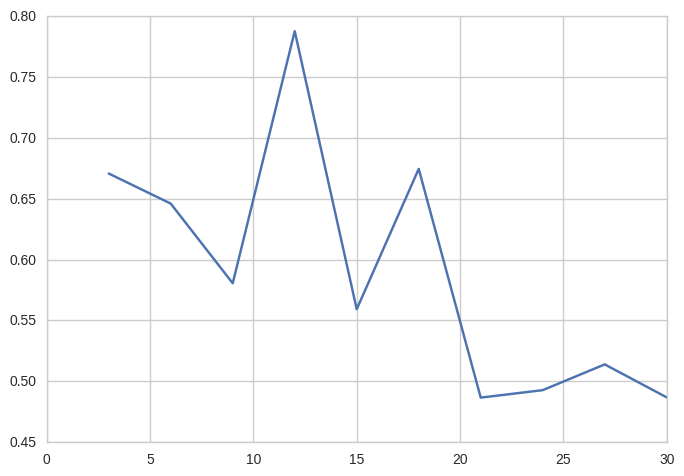

In [155]:
plt.plot(models_ave_dis.n_topics, models_ave_dis.avg_dist)

### Perplexity

In [169]:
from IPython.display import Image

Do we need to build models with holdout data / cross fold / etc in order to get this metric accuratly (see [paper] [0] and below)?

[0]: https://drive.google.com/file/d/0B0yNqBPIMNytdUF5OEVzWDRqcFk/view

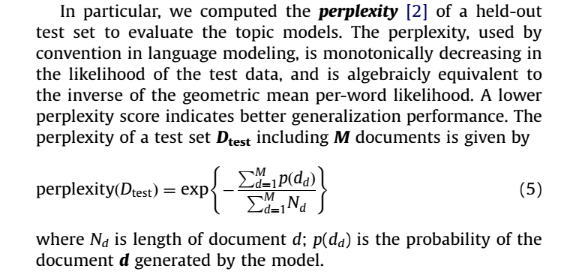

In [170]:
Image(filename='images/perplexity_def.png')

Below we use sklearn's perpelxity measure (see [here] [0] and [here] [1])

[0]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
[1]: https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/decomposition/online_lda.py#L675

In [162]:
perplexity = [{'n_topics' : key,
               'perp' : models[key].model.perplexity(doc_term_matrix)} \
              for key in models.keys()]

In [163]:
perplexity = pandas.DataFrame(perplexity)
perplexity.sort_values(by='n_topics', inplace=True)

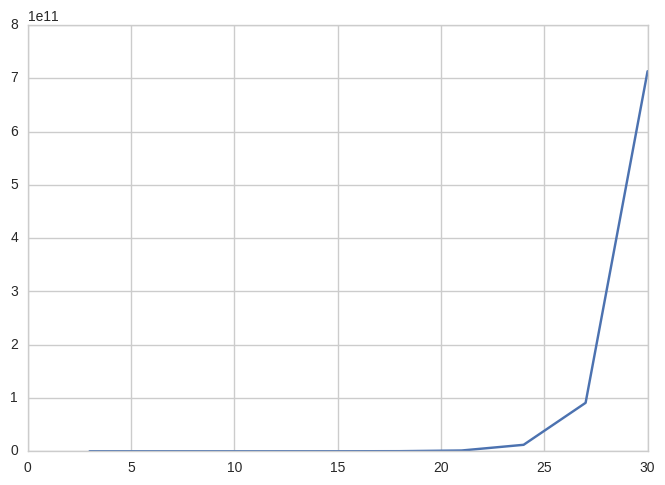

In [168]:
plt.plot(perplexity.n_topics, perplexity.perp)

In [165]:
perplexity

,n_topics,perp
1,3,2.996926e+03
3,6,3.401317e+04
5,9,3.205789e+05
7,12,2.534031e+06
9,15,2.160770e+07
0,18,1.793491e+08
2,21,1.459009e+09
4,24,1.214828e+10
6,27,9.094428e+10
8,30,7.133521e+11
